# Part a
This notebook contains a step-by-step walkthrough of task a) using both code and text.

In [2]:
%load_ext autoreload
%autoreload 2
#Add own modules to path
import sys
sys.path.append('../../src/')

### Loading the data and constructing the design matrix
In this part the terrain data used in previous project will be used again. 100x100 data points is extracted from the data and will be the default amount of data points.

For simplicity one function has been created and is used to load the data and create the design matrix. Degree 4 is choosen for the polynomial design matrix and will be used in further analyses.

In [174]:
from data.create_dataset import create_dataset
X, z = create_dataset('../../data/raw/SRTM_data_Norway_1.tif',degree=4) 

### Splitting and plotting the data

../../src\visualization\visualize.py:42: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  surf = ax.plot_surface(xi, yi, zi, cmap=cm.coolwarm,


<Axes3DSubplot:title={'center':'Test data'}, xlabel='X', ylabel='Y'>

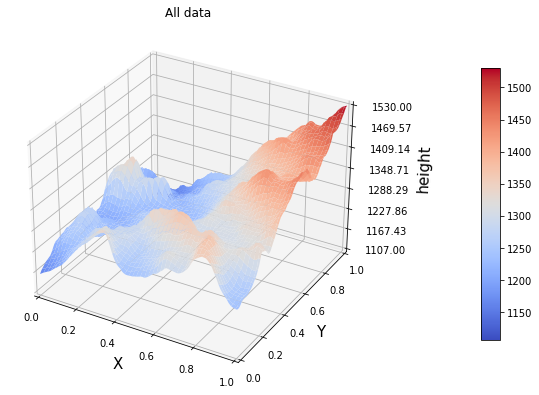

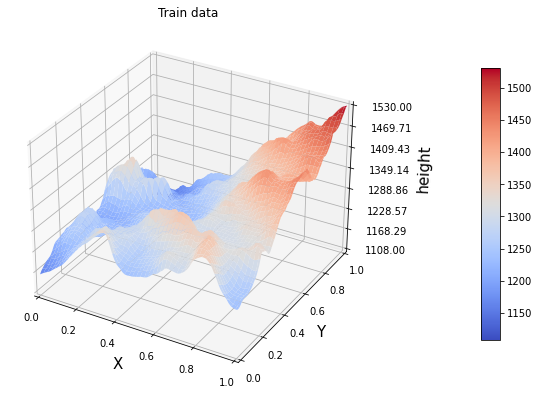

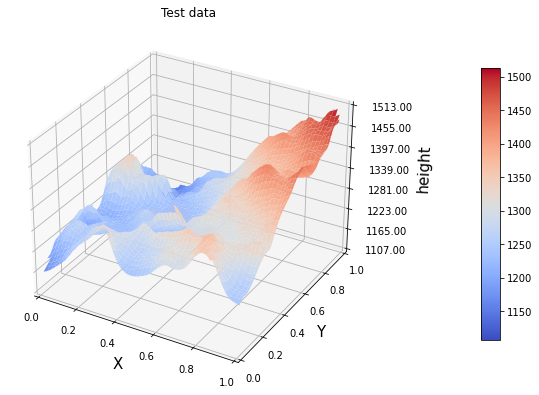

In [175]:
from visualization.visualize import plot_surf_from_X
from sklearn.model_selection import  train_test_split

X_train, X_test, z_train, z_test = train_test_split(X,z, test_size=0.2)

plot_surf_from_X(X,z,'All data')
plot_surf_from_X(X_train,z_train,'Train data')
plot_surf_from_X(X_test,z_test,'Test data')

Above plots shows z, z_train and z_test plotted on a 2 by 2 grid spanning 0 to 1. Cubic interpolation is used to fill in the blanks, but some are not possible to interpolate to because they lie outside the convex hull of the data, meaning there's no data point on the other side to use in interpolation.

As can be seen, they're not very easy to distinguish to the naked eye, but it is at least clear from the test data that some details are missing given it's smooth curves.

Anyhow, interpolation enables us to plot a smooth surface containing the predicted values of our future model.

### Scaling the data
The data will be scaling using SKlearns StandardScaler. Here standardization is used by subtracting the mean and dividing by std. The reason is that it helps the stochastic gradient descent algorithm converge faster, as it reduces the amount of steps needed to reach a good or optimal solution. This is because when standardizing there are less ravines(i.e mixture of steep and flat directions), which an sgd algorithm doesn't tend to handle very well. A steep hill will cause a big gradient that may in turn cause the sgd to overshoot at the next step. Standardizing ensures the parameter space is homogenous(i.e error ellipsis shown in image is more circular).
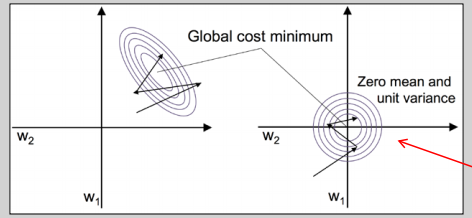

../../src\visualization\visualize.py:42: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  surf = ax.plot_surface(xi, yi, zi, cmap=cm.coolwarm,


<Axes3DSubplot:title={'center':'Scaled test data'}, xlabel='X', ylabel='Y'>

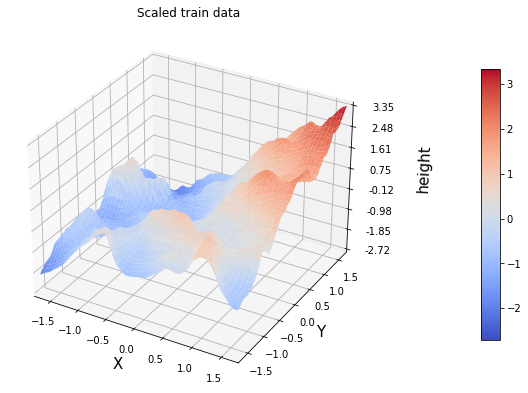

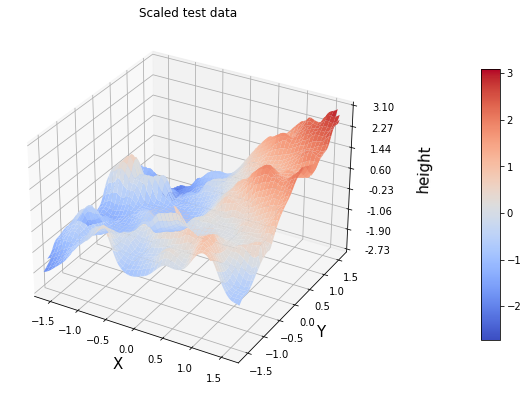

In [176]:
from sklearn.preprocessing import StandardScaler
X_scl = StandardScaler().fit(X_train)
z_scl = StandardScaler().fit(z_train)

X_train = X_scl.transform(X_train)
X_test = X_scl.transform(X_test)
z_train = z_scl.transform(z_train)
z_test = z_scl.transform(z_test)
plot_surf_from_X(X_train,z_train,'Scaled train data')
plot_surf_from_X(X_test,z_test,'Scaled test data')

### Revisiting regular OLS and Ridge
OLS and Ridge using matrix inversion was studied in former project, but will be presented here to provide basis for comparison.

In [200]:
from modelling import ols,ridge
lmb = 0.1
beta_ols = ols.fit_beta(X_train,z_train,fit_intercept=False)
beta_rid = ridge.fit_beta(X_train,z_train, lmb,fit_intercept=False)
print('OLS\t','\tRidge')
print(np.column_stack((beta_ols,beta_rid)))

OLS	 	Ridge
[[ 0.          0.        ]
 [ 2.99646122  2.42156016]
 [ 1.71282057  1.34389274]
 [-6.51222228 -4.6973083 ]
 [-7.05465476 -6.23570482]
 [-3.41477381 -2.37894052]
 [ 7.38171898  5.30328815]
 [ 9.23526044  8.2270035 ]
 [ 2.45541091  1.85295155]
 [ 4.61231847  3.40587653]
 [-3.7305605  -2.91521855]
 [-1.81660435 -1.42121055]
 [-3.82955327 -3.54768452]
 [ 1.87371171  2.02767754]
 [-3.03374104 -2.5320508 ]]


The columns above show beta values for ols and ridge respectively. As can be seen, some of the higher parameters have been dampened with Ridge

OLS train[MSE,R2]: (0.11315806935181798, 0.8868419306481821) 
OLS test[MSE,R2]: (0.108865323557341, 0.8942312198974585)
Ridge train[MSE,R2]: (0.11375086667522318, 0.8862491333247768) 
Ridge test[MSE,R2]: (0.10923044485622768, 0.8938764840356543)


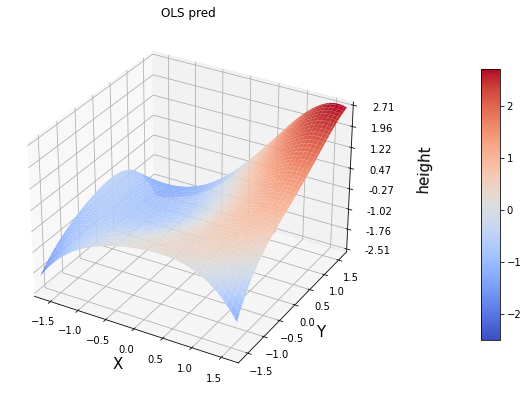

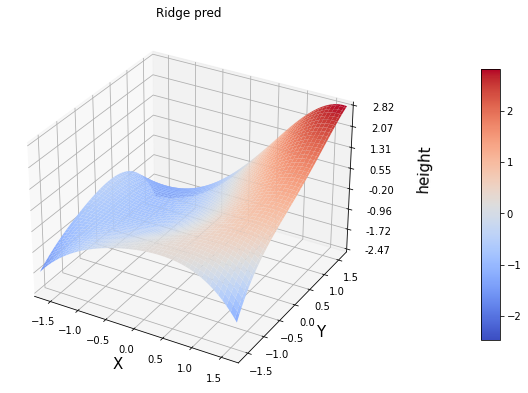

In [201]:
from model_evaluation.metrics import score_model
#Score the models
t_ols, p_ols, (train_mse_ols, train_r2_ols), (test_mse_ols, test_r2_ols) = ols.score_model(X_train,X_test,
                                                                                           z_train,z_test,
                                                                                           beta_ols)
t_rid, p_rid, (train_mse_rid, train_r2_rid), (test_mse_rid, test_r2_rid) = ridge.score_model(X_train,X_test,
                                                                                             z_train,z_test,
                                                                                             beta_rid)

#Concatenating X_train and X_test so that we 
#can plot the whole predicted surface
X_ = np.concatenate((X_train,X_test))

plot_surf_from_X(X_,np.concatenate((t_ols,p_ols)),'OLS pred')
plot_surf_from_X(X_,np.concatenate((t_rid,p_rid)),'Ridge pred')

#Printing the scores
print('OLS train[MSE,R2]:',(train_mse_ols, train_r2_ols), '\nOLS test[MSE,R2]:',(test_mse_ols, test_r2_ols))
print('Ridge train[MSE,R2]:',(train_mse_rid, train_r2_rid), '\nRidge test[MSE,R2]:',(test_mse_rid, test_r2_rid))

The scores indicate a relatively good fit. The MSE is low in both cases, the scale is also quite low, however we also see that the R2 score is quite close to 1, indicating a good fit. From the looks of it, the surfaces doesn't look very much like the original, but a lot smoother. If the goal is to recreate terrain for visual purposes we might require an even better score.

### Regression using stochastic gradient descent
In place of matrix inversion when fitting parameters, we will in this case use sgd optimization.
To begin with, some parameters are set rather arbitrarily. Batch_size is 128 as a multiplum of 2 often enables more efficient vectorized calculations. The number of epochs are set to 100, which is low but demonstrates how sgd needs certain amounts of epochs to converge. Learning rate is set to 0.01, and when using regularization, lmb is set to 0.001.

In [229]:
from modelling.sgd import SGD_optimizer

#initialize SGD optimizer object
sgd_ols = SGD_optimizer(fit_intercept = False, batch_size = 128, 
                        n_epochs = 100,use_momentum= False,
                        regularization = None, lr0=0.01)
sgd_rid = SGD_optimizer(fit_intercept = False, batch_size = 128, 
                        n_epochs = 100,use_momentum= False,
                        regularization = 'l2',lmb=0.001, lr0=0.01)

#Fit sgd optimizer
sgd_ols.fit(X_train,z_train)
sgd_rid.fit(X_train,z_train)

#Print parameters
print('OLS SGD\t','\tRidge SGD', '  OLS','\tRidge')
print(np.column_stack((sgd_ols.beta,sgd_rid.beta,beta_ols,beta_rid)))

OLS SGD	 	Ridge SGD   OLS 	Ridge
[[ 0.          0.          0.          0.        ]
 [ 0.26616816  0.2638332   2.99646122  2.42156016]
 [-0.05924933 -0.06647162  1.71282057  1.34389274]
 [ 0.39663086  0.38602135 -6.51222228 -4.6973083 ]
 [-0.26765314 -0.26060571 -7.05465476 -6.23570482]
 [-0.04223639 -0.04432959 -3.41477381 -2.37894052]
 [ 0.02566942  0.02273365  7.38171898  5.30328815]
 [ 0.35548377  0.34936093  9.23526044  8.2270035 ]
 [-0.06511386 -0.06135364  2.45541091  1.85295155]
 [-0.06596538 -0.06499591  4.61231847  3.40587653]
 [-0.49734302 -0.48726923 -3.7305605  -2.91521855]
 [ 0.30867027  0.3066159  -1.81660435 -1.42121055]
 [ 0.34660701  0.34638492 -3.82955327 -3.54768452]
 [ 0.18608471  0.18266869  1.87371171  2.02767754]
 [-0.15825002 -0.15309374 -3.03374104 -2.5320508 ]]


We see that the parameters resulting from the SGDs does have a way to go to reach the analytical solutions. Note that since the cost functions(both with and without regularization) are convex, the sgd should converge to the analytical solution with enough epochs and low enough learning rate.

Increasing n_epochs drastically to 100 000

In [276]:
from modelling.sgd import SGD_optimizer
#initialize SGD optimizer object
sgd_ols = SGD_optimizer(fit_intercept = False, batch_size = 128,
                        n_epochs = 100000, use_momentum= False, 
                        regularization = None,
                        schedule = 'constant', lr0=0.01)
sgd_rid = SGD_optimizer(fit_intercept = False, batch_size = 128, 
                        n_epochs = 100000,use_momentum= False, 
                        regularization = 'l2',lmb=0.001, 
                        schedule = 'constant', lr0=0.01)

#Fit sgd optimizer
sgd_ols.fit(X_train,z_train)
sgd_rid.fit(X_train,z_train)

#Print parameters
print('OLS SGD\t','\tRidge SGD', '  OLS','\tRidge')
print(np.column_stack((sgd_ols.beta,sgd_rid.beta,beta_ols,beta_rid)))

OLS SGD	 	Ridge SGD   OLS 	Ridge
[[ 0.          0.          0.          0.        ]
 [ 2.81308553  2.60148273  2.99646122  2.42156016]
 [ 1.59911626  1.45031407  1.71282057  1.34389274]
 [-5.85057699 -5.2509912  -6.51222228 -4.6973083 ]
 [-6.91068563 -6.50513149 -7.05465476 -6.23570482]
 [-3.01996215 -2.68802973 -3.41477381 -2.37894052]
 [ 6.5220438   5.91475759  7.38171898  5.30328815]
 [ 9.0587907   8.55731212  9.23526044  8.2270035 ]
 [ 2.33035073  2.04662725  2.45541091  1.85295155]
 [ 4.11152118  3.76250898  4.61231847  3.40587653]
 [-3.36538267 -3.15702657 -3.7305605  -2.91521855]
 [-1.73016954 -1.55188715 -1.81660435 -1.42121055]
 [-3.79719437 -3.64055562 -3.82955327 -3.54768452]
 [ 1.92568296  1.97945565  1.87371171  2.02767754]
 [-2.8230506  -2.68220938 -3.03374104 -2.5320508 ]]


We are getting very close with 100 000 epochs

In [268]:
epochs = 500
sgd_ols2 = SGD_optimizer(fit_intercept = False, batch_size = 256, 
                        n_epochs = epochs,use_momentum= False,
                        regularization = None,lmb=0.001, lr=0.01)
sgd_rid2 = SGD_optimizer(fit_intercept = False, batch_size = 256, 
                        n_epochs = epochs,use_momentum= False,
                        regularization = 'l2',lmb=0.001, lr=0.01)
sgd_rid2.fit(X_train,z_train)
sgd_ols2.fit(X_train,z_train)
print(np.column_stack((sgd_ols2.beta,sgd_rid2.beta)))

[[ 0.          0.        ]
 [ 0.22585645  0.12855422]
 [ 0.03908334  0.09194679]
 [ 0.67482205  0.90106153]
 [-0.60306348 -0.862652  ]
 [ 0.01526775  0.05342314]
 [ 0.11426355  0.22407514]
 [ 0.53326757  0.79623876]
 [-0.17835877 -0.2463931 ]
 [-0.05243579 -0.02302164]
 [-0.8092583  -1.06829735]
 [ 0.36265899  0.41497755]
 [ 0.31996038  0.06559447]
 [ 0.3725309   0.64928044]
 [-0.27114221 -0.39080332]]


In [236]:
from sklearn.linear_model import SGDRegressor
sgd_sk = SGDRegressor(fit_intercept = False, max_iter = 1000, penalty=None, eta0 = 0.01,tol=None)
sgd_sk.fit(X_train,z_train.ravel())

SGDRegressor(fit_intercept=False, max_iter=12800, penalty=None, tol=None)

In [237]:
sgd_sk.coef_.T

array([ 0.        ,  1.65469568,  0.80573445, -2.17264507, -5.19580689,
       -0.84172032,  2.27728335,  7.11752101,  0.86900144,  1.73018524,
       -1.68859521, -0.96250737, -3.26643981,  2.41178734, -1.90080655])